### Modeling for Predicting C02 emissions

In [4]:
# Modeling for Predicting C02 emissions
# requires modules and libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [157]:
# Load the dataset
data = pd.read_csv('route_emissions_dataset.csv',on_bad_lines='skip', encoding='latin1')
data.head()

,distance_km,avg_speed_kmph,vehicle_type,traffic_level,co2_emission
0,61.5,75,bike,low,2460.0
1,4.9,29,bike,medium,235.2
2,11.6,41,car,low,1392.0
3,3.4,40,car,medium,489.6
4,47.2,20,bike,high,2832.0


### Feature Engineering and Data Preprocessing

In [158]:
data.rename(columns={
    'distance_km': 'distance',
    'avg_speed_kmph': 'avg_speed',
    'vehicle_type': 'vehicle',
    'traffic_level': 'traffic',
},inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   distance      10000 non-null  float64
 1   avg_speed     10000 non-null  int64  
 2   vehicle       10000 non-null  object 
 3   traffic       10000 non-null  object 
 4   co2_emission  10000 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 390.8+ KB


In [159]:
# converting categorical features and engineering new features
vechile_weight_map = {
    'car': 1500, 'bike': 150
}
traffic_impact_map = {
    'low':1.0, 'medium':1.4, 'high':2.5
}
data['vehicle'] = data['vehicle'].map(vechile_weight_map)
data['traffic'] = data['traffic'].map(traffic_impact_map)

In [160]:
data['congestion_factor'] = data['traffic']*data['distance']
data['effective_speed'] = data['avg_speed'] / data['traffic']
data['stress_score'] = data['vehicle'] * data['congestion_factor'] 

In [161]:
data.head()

,distance,avg_speed,vehicle,traffic,co2_emission,congestion_factor,effective_speed,stress_score
0,61.5,75,150,1.0,2460.0,61.50,75.000000,9225.0
1,4.9,29,150,1.4,235.2,6.86,20.714286,1029.0
2,11.6,41,1500,1.0,1392.0,11.60,41.000000,17400.0
3,3.4,40,1500,1.4,489.6,4.76,28.571429,7140.0
4,47.2,20,150,2.5,2832.0,118.00,8.000000,17700.0


In [162]:
duplicate_count = data.duplicated().sum()
print(f"Total duplicate rows found: {duplicate_count}")
data.drop_duplicates(inplace=True)
data.reset_index(drop=True, inplace=True)
print(f"Data shape after removing duplicates: {data.shape}")

Total duplicate rows found: 349
Data shape after removing duplicates: (9651, 8)


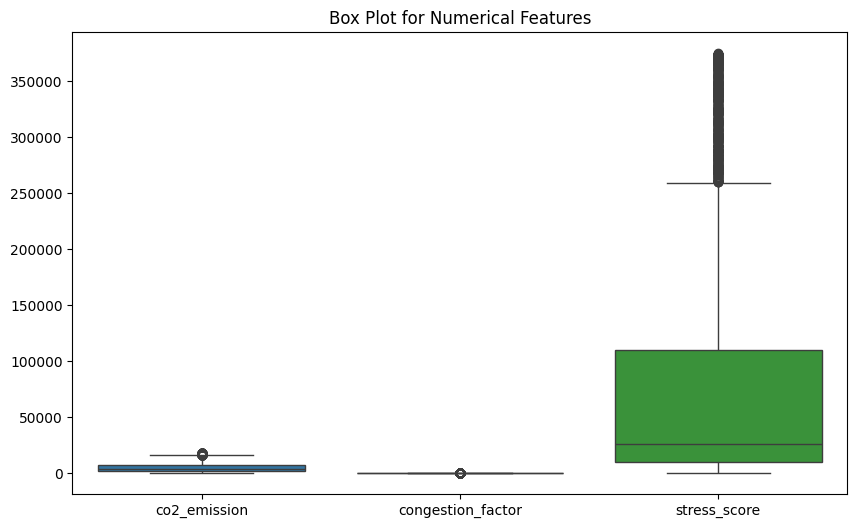

In [163]:
#box plot to check for outliers
plt.figure(figsize=(10,6))
sns.boxplot(data=data[['co2_emission','congestion_factor','stress_score']])
plt.title('Box Plot for Numerical Features')
plt.show()

In [108]:
def remove_outliers_iqr(df, column):
    # Calculate bounds
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter: Keep only rows INSIDE the bounds
    df_clean = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    return df_clean

In [109]:
initial_count = len(data)
print(f"Original Data Size: {initial_count} rows")

df_clean = remove_outliers_iqr(data, 'stress_score')
df_clean = remove_outliers_iqr(df_clean, 'congestion_factor')
df_clean = remove_outliers_iqr(df_clean, 'co2_emission')

# You can add 'distance' or 'avg_speed' if needed
# df_clean = remove_outliers_iqr(df_clean, 'distance')

# 3. Calculate Loss
final_count = len(df_clean)
lost_count = initial_count - final_count
percentage_lost = (lost_count / initial_count) * 100

print(f"Final Data Size:    {final_count} rows")
print(f"Rows Deleted:       {lost_count}")
print(f"Data Loss:          {percentage_lost:.2f}%")

# 4. Save the result
data = df_clean.copy()

Original Data Size: 9651 rows
Final Data Size:    8784 rows
Rows Deleted:       867
Data Loss:          8.98%


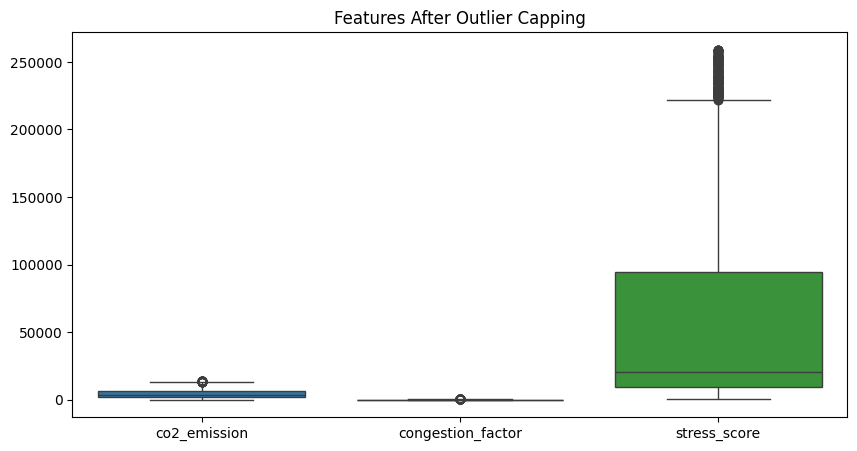

In [110]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=data[['co2_emission', 'congestion_factor', 'stress_score']])
plt.title('Features After Outlier Capping')
plt.show()

### Modeling 

In [178]:

X = data[['distance', 'avg_speed', 'vehicle', 'traffic', 'congestion_factor', 'effective_speed', 'stress_score']]
y = data['co2_emission']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training Samples: {X_train.shape}\nTesting Samples: {X_test.shape}")

Training Samples: (7720, 7)
Testing Samples: (1931, 7)


In [179]:
print(X.columns)
print(y.name)

Index(['distance', 'avg_speed', 'vehicle', 'traffic', 'congestion_factor',
       'effective_speed', 'stress_score'],
      dtype='object')
co2_emission


In [183]:
model = XGBRegressor(
    base_score=0.5, booster='gbtree', call_back=None, colsample_bylevel=1, colsample_bynode=1,
    colsample_bytree=1, gamma=0, importance_type='gain',device='cpu',early_stopping_rounds=10, 
    eval_metric='rmse', n_jobs=-1,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
y_pred = model.predict(X_test)

### Model Evaluation

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r_score = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R2-Score: {r_score}")

Mean Squared Error: 615.46
Mean Absolute Error: 17.75
R2-Score: 0.9999617085758191


In [ ]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_score = r2_score(y_train, y_train_pred)
test_score = r2_score(y_test, y_test_pred)

print(f"Training R2: {train_score}")
print(f"Testing  R2: {test_score}")
print(f'Difference in R2: {train_score - test_score}')

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"\nTraining RMSE: {train_rmse:.2f}")
print(f"Testing  RMSE: {test_rmse:.2f}")
print(f'Difference in RMSE: {train_rmse - test_rmse }')

Training R2: 0.9999740733488969
Testing  R2: 0.9999617085758191
Difference in R2: 1.2364773077755409e-05

Training RMSE: 21.39
Testing  RMSE: 24.81
Difference in RMSE: -3.419014144479398


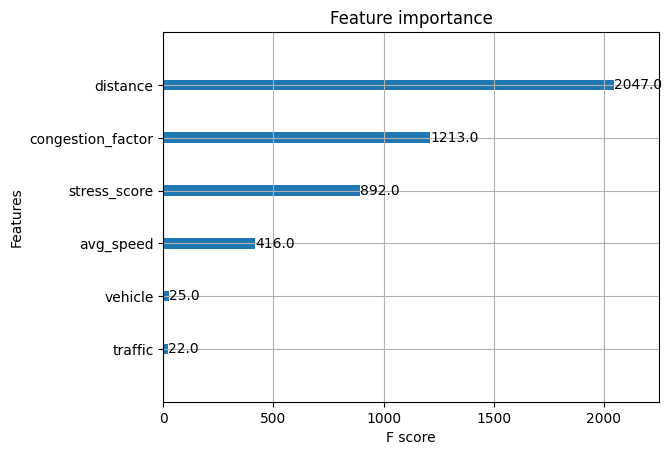

In [197]:
# feature importance
from xgboost import plot_importance
plot_importance(model)
plt.show()